# Linear and KNN Regression on Combined Cycle Power Plant Data Set

In [1]:
import math
import operator
import html5lib
import warnings
import numpy as np
import pandas as pd
import openpyxl as xl
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import preprocessing
from beautifultable import BeautifulTable
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
warnings.simplefilter(action='ignore', category=FutureWarning) 

In [2]:
# arrange data in a table
def printDatainTable(tableHeaders, tableData):
    table = BeautifulTable(maxwidth=100)
    table.column_headers = tableHeaders
    for i in range(0, len(tableData)):
        table.append_row(tableData[i])
    print(table)

In [3]:
def LinearRegression(dataX, dataY):
    # fit linear regression model
    model = sm.OLS(dataY, dataX).fit()
    
    # find model coefficients 
    coefficients = model.params
    
    # find R^2 value of the model
    r2Value = round(model.rsquared, 2)
    
    # find t-value
    tValues = model.tvalues
    
    # find p-values
    pValues = model.pvalues
    
    # round off coeeficients, t-values and p-values 
    for j in range(0, len(coefficients)):
        coefficients[j] = round(coefficients[j], 3)
        tValues[j] = round(tValues[j], 2)
        pValues[j] = round(pValues[j], 2)
        
    return coefficients, r2Value, tValues, pValues, model

In [4]:
# Fit KNN regression model on training set 
# and compute testing error for different values of K
def KNNRegression(trainDataX, trainDataY, testDataX, testDataY):
    trainDataX = np.array(trainDataX)
    trainDataY = np.array(trainDataY)
    testDataX = np.array(testDataX)
    testDataY = np.array(testDataY)
    
    errorDict = {}
    for K in range(1, 101):
        KNN = KNeighborsRegressor(n_neighbors = K)

        # Fit training data on KNN regression model
        KNN.fit(trainDataX, trainDataY)
        
        # Predict on testing data
        predictedY = KNN.predict(testDataX)
        
        # Calculate Mean Squared Error
        MSE = np.mean((predictedY-testDataY)**2)
        MSE = round(MSE, 3)
        errorDict[1/K] = MSE
        
    return errorDict

In [5]:
# Compute studentized residual for outliers detection
def findStudentizedResidual(dataX, dataY, predictedY):
    n = len(dataY)
    
    # compute average feature value
    avgX = 0.0
    for i in range(0, n):
        avgX += dataX[i]
    avgX /= n
    
    # compute variance
    variance = 0
    for i in range(0, n):
        variance += (dataX[i]-avgX)*(dataX[i]-avgX)
       
    # compute mean-squared error of the model
    mse = mean_squared_error(dataY, predictedY)
       
    # compute studentized residual for each observation
    studentizedResidual = []
    for i in range(0, n):
        observationError = dataY[i]-predictedY[i]
        leverageStat = 1/n + ((dataX[i]-avgX)*(dataX[i]-avgX))/variance
        sResidual = observationError/(math.sqrt(mse*(1-leverageStat)))
        studentizedResidual.append(sResidual)
    
    return studentizedResidual

In [6]:
# Plot linear regression line for single predictor vs response
def plotRegressionLine(dataX, dataY, predictorName, responseName, slope, intercept, r2Value, title):
    # scatter plot of predictor and response data
    plt.scatter(dataX, dataY, s=1)
    
    lineX = np.arange(dataX.min(), dataX.max())
    
    # find predicted responses
    lineY = slope*lineX + intercept
    
    # define regression line equation
    lineEquation = str(intercept) + '+' + predictorName + '*' + str(slope)
    
    label = lineEquation + ', R^2=' + str(r2Value)
    plt.plot(lineX, lineY, 
             label=label, color='black')
    plt.legend(loc='best')
    plt.title(title)
    plt.xlabel(predictorName)
    plt.ylabel(responseName)
    plt.show()

In [7]:
# Normalize training and testing features data in range 0-1
def normalizeFeatureData(trainDataX, testDataX):
    #Normalize feature data
    minMaxScaler = preprocessing.MinMaxScaler()

    # Create an object to transform the data to fit minmax processor
    scaledTrainDataX = minMaxScaler.fit_transform(trainDataX)
    scaledTestDataX = minMaxScaler.fit_transform(testDataX)

    # Run the normalizer on the dataframe
    normalizedTrainDataX = pd.DataFrame(scaledTrainDataX)
    normalizedTestDataX = pd.DataFrame(scaledTestDataX)
    
    return normalizedTrainDataX, normalizedTestDataX

In [8]:
# Plot train and test error for different values of K
def plotTrainTestError(trainErrorDict, testErrorDict, trainLabel, testLabel):
    # plot K vs training error 
    plt.plot(trainErrorDict.keys(), trainErrorDict.values(), 'r', label = trainLabel)
        
    # plot K vs testing error
    plt.plot(testErrorDict.keys(), testErrorDict.values(), 'b', label = testLabel)
    
    plt.title('Error vs Value of 1/K')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('1/K')
    plt.legend()
    plt.show()

# 

# 1. (b) Exploring the data:

# (b) i. rows and columns

In [9]:
df = pd.read_excel('../data/CCPP/Folds5x2_pp.xlsx', engine='openpyxl')
columnList = df.columns.tolist()
independentVar = columnList[:len(columnList)-1]
dependentVar = columnList[len(columnList)-1]
rowCnt = len(df.index)
columnCnt = len(columnList)
independentVarCnt = len(independentVar)
print("No. of rows in the data set:", rowCnt)
print("No. of columns in the data set:", columnCnt)
print("A row describes a single entity or observation and the columns describe properties about that entity or observation")

No. of rows in the data set: 9568
No. of columns in the data set: 5
A row describes a single entity or observation and the columns describe properties about that entity or observation


# (b) ii. scatter plot

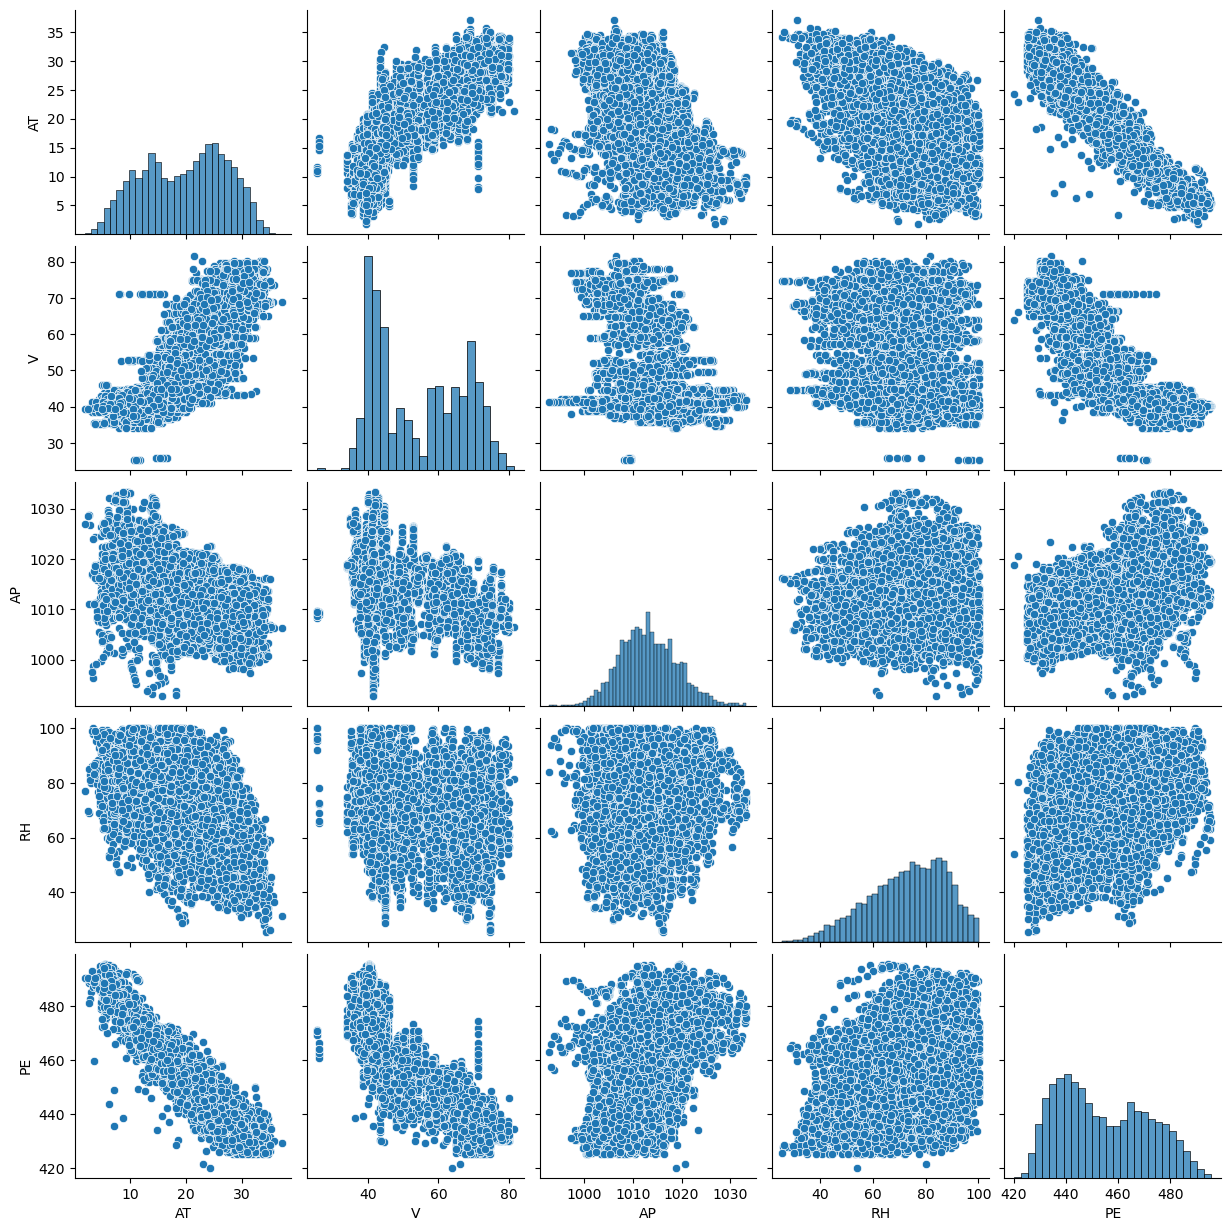

In [10]:
sns.pairplot(data=df)

# (b) iii. data stats

In [11]:
dataStat = df.describe()

meanList = dataStat[1:2].values[0].tolist()
medianList = dataStat[5:6].values[0].tolist()
minVal = dataStat[3:4].values[0].tolist()
maxVal = dataStat[7:8].values[0].tolist()
firstQuart = dataStat[4:5].values[0].tolist()
thirdQuart = dataStat[6:7].values[0].tolist()

rangeList = []
for i in range(0, len(minVal)):
    rangeList.append(maxVal[i] - minVal[i]) 

interQuart = []
for i in range(0, len(firstQuart)):
    interQuart.append(thirdQuart[i] - firstQuart[i])


meanList.insert(0,'Mean')
medianList.insert(0, 'Median')
rangeList.insert(0, 'Range')
firstQuart.insert(0, 'First Quartile')
thirdQuart.insert(0, 'Third Quartile')
interQuart.insert(0, 'Inter-Quartile Range')

statInTable = []
statInTable.append(meanList)
statInTable.append(medianList)
statInTable.append(rangeList)
statInTable.append(firstQuart)
statInTable.append(thirdQuart)
statInTable.append(interQuart)

tableHeader = columnList[:]
tableHeader.insert(0, 'Statistics') 

printDatainTable(tableHeader, statInTable)


+----------------------+--------+--------+----------+--------+---------+
|      Statistics      |   AT   |   V    |    AP    |   RH   |   PE    |
+----------------------+--------+--------+----------+--------+---------+
|         Mean         | 19.651 | 54.306 | 1013.259 | 73.309 | 454.365 |
+----------------------+--------+--------+----------+--------+---------+
|        Median        | 20.345 | 52.08  | 1012.94  | 74.975 | 451.55  |
+----------------------+--------+--------+----------+--------+---------+
|        Range         |  35.3  |  56.2  |  40.41   |  74.6  |  75.5   |
+----------------------+--------+--------+----------+--------+---------+
|    First Quartile    | 13.51  | 41.74  |  1009.1  | 63.328 | 439.75  |
+----------------------+--------+--------+----------+--------+---------+
|    Third Quartile    | 25.72  | 66.54  | 1017.26  | 84.83  | 468.43  |
+----------------------+--------+--------+----------+--------+---------+
| Inter-Quartile Range | 12.21  |  24.8  |   8.16  

# (c) Fit a simple linear regression model for each predictor

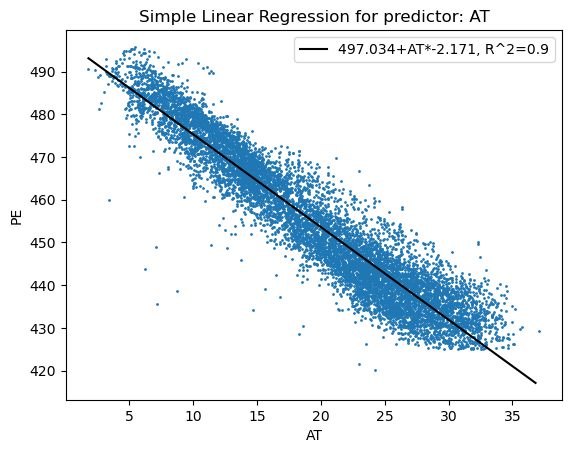

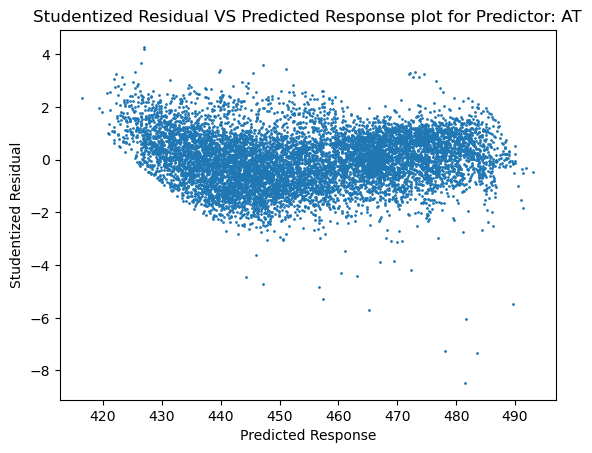

+-----------+-------------+---------+---------+------------------------+
| Predictor | Coefficient | t-value | p-value |        Comments        |
+-----------+-------------+---------+---------+------------------------+
| Constant  |   497.034   | 3177.28 |   0.0   |                        |
+-----------+-------------+---------+---------+------------------------+
|    AT     |   -2.171    | -291.72 |   0.0   | Significant predictor. |
|           |             |         |         |   Outliers present.    |
+-----------+-------------+---------+---------+------------------------+
R^2 Value with AT predictor:  0.9

R^2 Value with AT predictor after removing outliers:  0.91


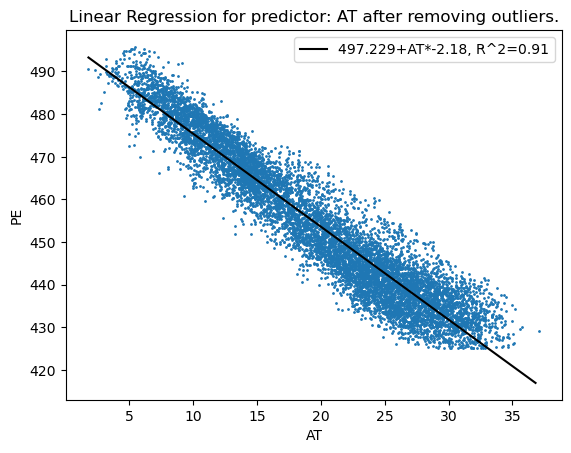

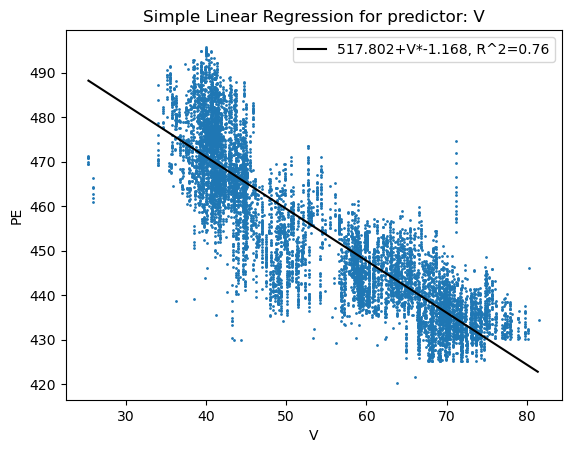

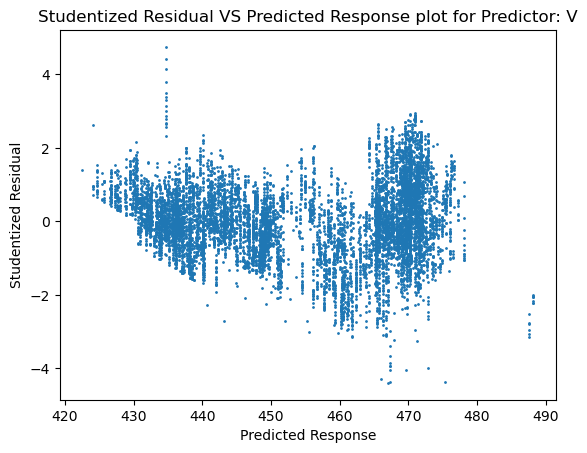

+-----------+-------------+---------+---------+------------------------+
| Predictor | Coefficient | t-value | p-value |        Comments        |
+-----------+-------------+---------+---------+------------------------+
| Constant  |   517.802   | 1370.22 |   0.0   |                        |
+-----------+-------------+---------+---------+------------------------+
|     V     |   -1.168    | -172.4  |   0.0   | Significant predictor. |
|           |             |         |         |   Outliers present.    |
+-----------+-------------+---------+---------+------------------------+
R^2 Value with V predictor:  0.76

R^2 Value with V predictor after removing outliers:  0.77


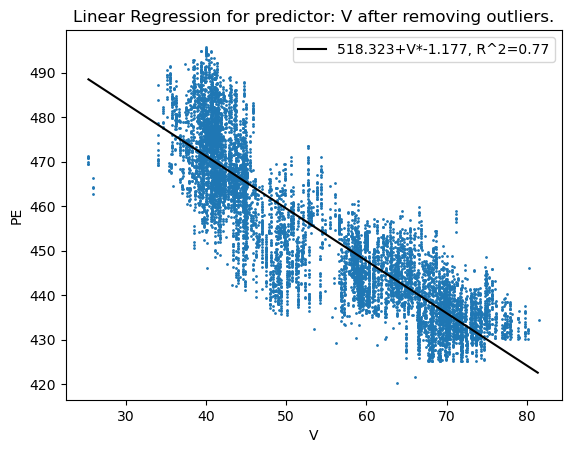

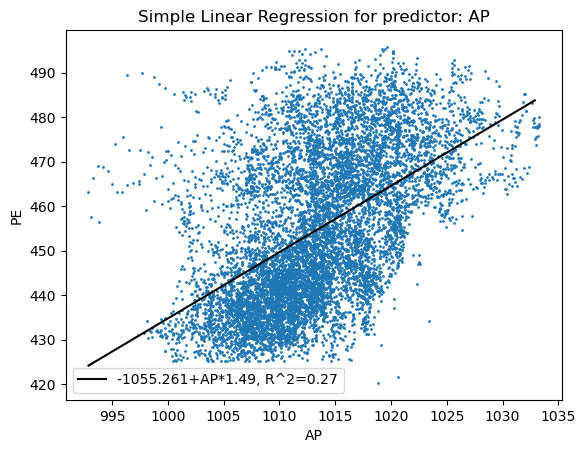

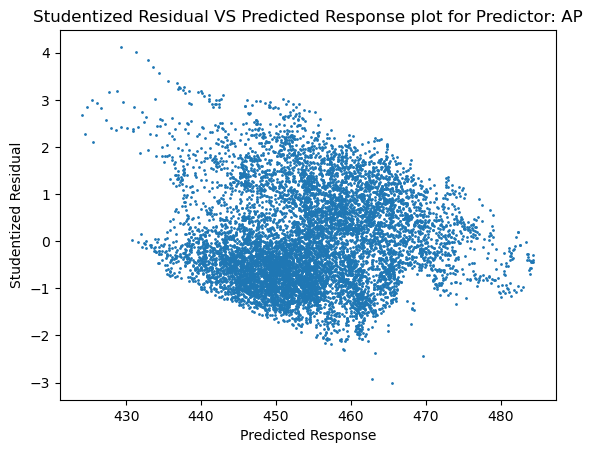

+-----------+-------------+---------+---------+------------------------+
| Predictor | Coefficient | t-value | p-value |        Comments        |
+-----------+-------------+---------+---------+------------------------+
| Constant  |  -1055.261  | -41.45  |   0.0   |                        |
+-----------+-------------+---------+---------+------------------------+
|    AP     |    1.49     |  59.3   |   0.0   | Significant predictor. |
|           |             |         |         |   Outliers present.    |
+-----------+-------------+---------+---------+------------------------+
R^2 Value with AP predictor:  0.27

R^2 Value with AP predictor after removing outliers:  0.28


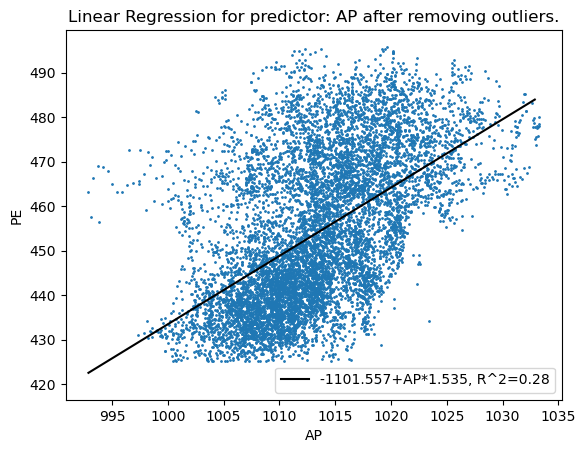

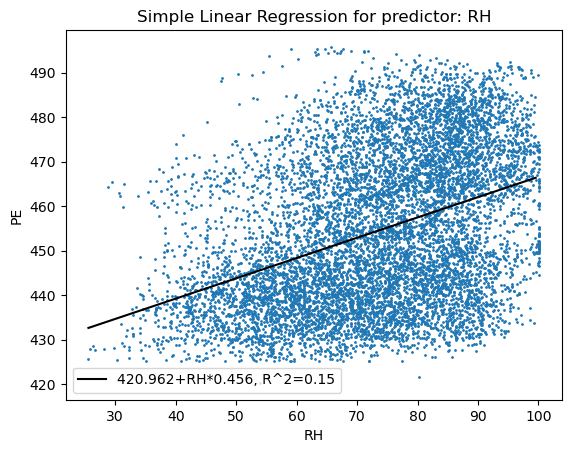

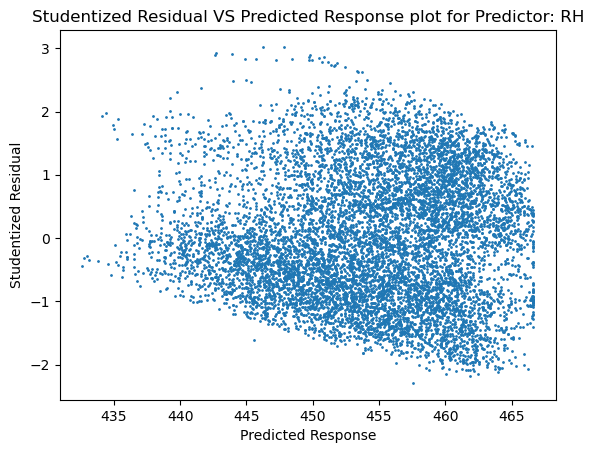

+-----------+-------------+---------+---------+------------------------+
| Predictor | Coefficient | t-value | p-value |        Comments        |
+-----------+-------------+---------+---------+------------------------+
| Constant  |   420.962   | 511.68  |   0.0   |                        |
+-----------+-------------+---------+---------+------------------------+
|    RH     |    0.456    |  41.4   |   0.0   | Significant predictor. |
|           |             |         |         |   Outliers present.    |
+-----------+-------------+---------+---------+------------------------+
R^2 Value with RH predictor:  0.15

R^2 Value with RH predictor after removing outliers:  0.15


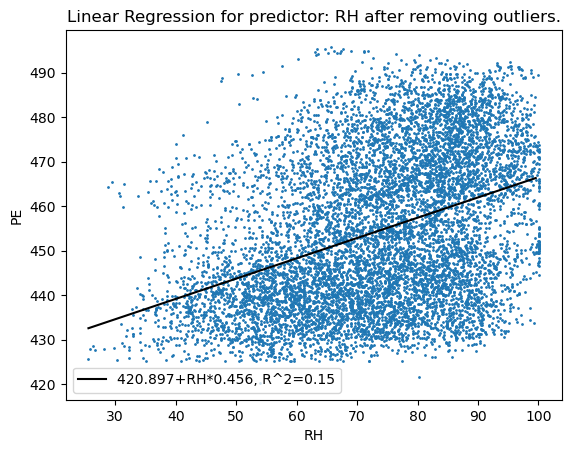

In [12]:
simpleRegressionCoefficients = {}
for i in range(0, len(independentVar)):
    predictor = independentVar[i]
    dataX = np.array(df[predictor]) 
    dataX = np.reshape(dataX, (len(dataX),1))
    dataX = sm.add_constant(dataX)
    dataY = np.array(df[dependentVar])
    
    #fit model
    coefficients, r2Value, tValues, pValues, model = LinearRegression(dataX, dataY)
    
    simpleRegressionCoefficients[predictor] = coefficients[1]
    
    #plot
    title = 'Simple Linear Regression for predictor: ' + predictor
    plotRegressionLine(dataX[:,1], dataY, predictor, dependentVar, coefficients[1], coefficients[0], r2Value, title)
    
    association = ''
    if pValues[1]<=0.05:
        association = 'Significant predictor.'
    else:
        association = 'Insignificant predictor.'
    
    predictedY = coefficients[0] + coefficients[1]*dataX[:,1]
    predictedY = np.array(predictedY).flatten()
    sResidual = findStudentizedResidual(dataX[:,1], dataY, predictedY)
    
    # plot predicted response vs studentized residual scatterplot
    plt.scatter(predictedY, sResidual, s=1)
    plt.xlabel('Predicted Response')
    plt.ylabel('Studentized Residual')
    plt.title('Studentized Residual VS Predicted Response plot for Predictor: ' + predictor)
    plt.show()
    
    newDataX = []
    newDataY = []
    #check if outliers are present
    hasOutlier = False
    
    for j in range(0, len(sResidual)):
        if abs(sResidual[j])>3:
            hasOutlier = True
        else:
            newDataX.append(dataX[j])
            newDataY.append(dataY[j])  
    
    if hasOutlier:
        outlier = 'Outliers present.'
    else:
        outlier = 'No outliers.' 
        
    #tabulate the results
    comments = association + '\n' + outlier
    tableData = []
    tableData.append(['Constant', coefficients[0], tValues[0], pValues[0], ''])
    tableData.append([predictor, coefficients[1], tValues[1], pValues[1], comments])
    
    tableHeaders = ['Predictor', 'Coefficient', 't-value', 'p-value', 'Comments']  
    printDatainTable(tableHeaders, tableData)
    print('R^2 Value with', predictor, 'predictor: ', r2Value)
    print()
    
    if hasOutlier:
        newDataX = np.array(newDataX)
        newDataY = np.array(newDataY)
        
        # Fit linear regression model
        coefficients, r2Value, tValues, pValues, model = LinearRegression(newDataX, newDataY)

        print('R^2 Value with', predictor, 'predictor after removing outliers: ', r2Value)

        # plot regression line for the predictor
        title = 'Linear Regression for predictor: ' + predictor + ' after removing outliers.'
        plotRegressionLine(newDataX[:,1], newDataY, predictor, dependentVar, 
                           coefficients[1], coefficients[0], r2Value, title) 

In [13]:
multipleRegressionCoefficients = {}

# (d) fit multiple linear regression

In [14]:

dataX = np.array(df[independentVar])
dataX = np.reshape(dataX, (len(dataX), len(independentVar)))
dataX = sm.add_constant(dataX)
dataY = np.array(df[dependentVar])

# Fit mutiple regression model
coefficients, r2Value, tValues, pValues, model = LinearRegression(dataX, dataY)
  
# add results to a table
tableData = []
tableData.append(['Constant', coefficients[0], tValues[0], pValues[0], ''])
for i in range(0, len(independentVar)):
    predictor = independentVar[i]
    multipleRegressionCoefficients[predictor] = coefficients[i+1]
    comments = ''
    if pValues[i+1]<=0.05:
        comments = 'Significant predictor. Reject the null hypothesis.'
    else:
        comments = 'Insignificant predictor. Failed to reject the null hypothesis.'
    tableData.append([predictor, coefficients[i+1], tValues[i+1], pValues[i+1], comments])

tableHeaders = ['Predictor', 'Coefficient', 't-value', 'p-value', 'Comments']
printDatainTable(tableHeaders, tableData)

print('R^2 Value for multiple regression: ', r2Value) 

print("\nComments: ")
print("When a single feature is used to predict the response, the r^2 value of the linear regression model for predictor: AT is maximum 0.9. However, the r^2 value of the linear regression model climbed to 0.93 when all the features were combined to predict the response.")

+-----------+-------------+---------+---------+----------------------------------------------------+
| Predictor | Coefficient | t-value | p-value |                      Comments                      |
+-----------+-------------+---------+---------+----------------------------------------------------+
| Constant  |   454.609   |  46.63  |   0.0   |                                                    |
+-----------+-------------+---------+---------+----------------------------------------------------+
|    AT     |   -1.978    | -129.34 |   0.0   | Significant predictor. Reject the null hypothesis. |
+-----------+-------------+---------+---------+----------------------------------------------------+
|     V     |   -0.234    | -32.12  |   0.0   | Significant predictor. Reject the null hypothesis. |
+-----------+-------------+---------+---------+----------------------------------------------------+
|    AP     |    0.062    |  6.56   |   0.0   | Significant predictor. Reject the null hypo

# (e) Plot of simple and multiple regression coefficients for each predictor.


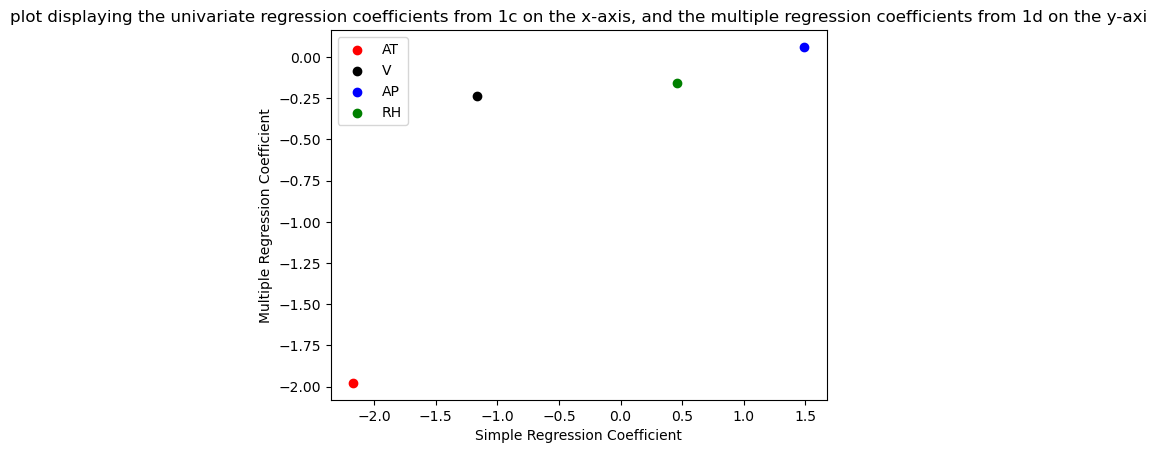

In [15]:
i = 0
color = ['red', 'black', 'blue', 'green']
for feature, simpleCoeff in simpleRegressionCoefficients.items():
    multipleCoeff = multipleRegressionCoefficients[feature]
    plt.scatter(simpleCoeff, multipleCoeff, color=color[i], label=feature)
    i += 1
plt.xlabel('Simple Regression Coefficient')
plt.ylabel('Multiple Regression Coefficient')
plt.title('plot displaying the univariate regression coefficients from 1c on the x-axis, and the multiple regression coefficients from 1d on the y-axi')
plt.legend()
plt.show()

# (f) Fit a model of the form Y=β0+β1X+β2X^2+β3X^3+E for each predictor

In [16]:
for i in range(0, len(independentVar)):
    dataX = np.array(df[independentVar[i]])
    dataX = np.reshape(dataX, (len(dataX), 1))
    polyFeatures = preprocessing.PolynomialFeatures(3, include_bias=False)
    transformedX = polyFeatures.fit_transform(dataX)
    transformedX = sm.add_constant(transformedX)
    dataY = np.array(df[dependentVar])
    
    # Fit linear regression model
    coefficients, r2Value, tValues, pValues, model = LinearRegression(transformedX, dataY)
    
    # add results to a table
    tableData = []
    tableData.append(['Constant', coefficients[0], tValues[0], pValues[0], ''])
    for j in range(1, 4):
        predictor = independentVar[i] + '^' + str(j)
        comments = ''
        if pValues[j]<=0.05:
            comments = 'Significant predictor.'
        else:
            comments = 'Insignificant predictor.'
        tableData.append([predictor, coefficients[j], tValues[j], pValues[j], comments])
    
    tableHeaders = ['Predictor', 'Coefficient', 't-value', 'p-value', 'Comments'] 
    print('Polynomial regression for feature:', independentVar[i])
    printDatainTable(tableHeaders, tableData)
    print('R^2 Value with', independentVar[i],'predictor:', r2Value)
    print()

Polynomial regression for feature: AT
+-----------+-------------+---------+---------+------------------------+
| Predictor | Coefficient | t-value | p-value |        Comments        |
+-----------+-------------+---------+---------+------------------------+
| Constant  |   492.728   | 732.25  |   0.0   |                        |
+-----------+-------------+---------+---------+------------------------+
|   AT^1    |    -0.61    |  -4.94  |   0.0   | Significant predictor. |
+-----------+-------------+---------+---------+------------------------+
|   AT^2    |   -0.125    |  -18.2  |   0.0   | Significant predictor. |
+-----------+-------------+---------+---------+------------------------+
|   AT^3    |    0.003    |  22.59  |   0.0   | Significant predictor. |
+-----------+-------------+---------+---------+------------------------+
R^2 Value with AT predictor: 0.91

Polynomial regression for feature: V
+-----------+-------------+---------+---------+--------------------------+
| Predictor 

# (g) Full linear regression model with all pairwise interaction terms

In [17]:
dataX = np.array(df[independentVar])
dataX = np.reshape(dataX, (len(dataX), len(independentVar)))
polyFeatures = preprocessing.PolynomialFeatures(2, interaction_only=True, include_bias=False)
transformedX = polyFeatures.fit_transform(dataX)
transformedX = sm.add_constant(transformedX)
dataY = np.array(df[dependentVar])

predictorCnt = len(transformedX[0])

# Fit linear regression model
coefficients, r2Value, tValues, pValues, model = LinearRegression(transformedX, dataY)

# add results to a table
tableData = []
idx = 1
tableData.append(['Constant', coefficients[0], tValues[0], pValues[0], ''])
for i in range(0, len(independentVar)):
    predictor = independentVar[i]
    comments = ''
    if pValues[idx]<=0.05:
        comments = 'Significant predictor.'
    else:
        comments = 'Insignificant predictor.'
    tableData.append([predictor, coefficients[idx], tValues[idx], pValues[idx], comments])
    idx += 1
    
for i in range(0, len(independentVar)):
    for j in range(i+1, len(independentVar)):
        predictor = independentVar[i] + '*' + independentVar[j]
        comments = ''
        if pValues[idx]<=0.05:
            comments = 'Significant predictor.'
        else:
            comments = 'Insignificant predictor.'
        tableData.append([predictor, coefficients[idx], tValues[idx], pValues[idx], comments])
        idx += 1

tableHeaders = ['Predictor', 'Coefficient', 't-value', 'p-value', 'Comments']
printDatainTable(tableHeaders, tableData)

print('R^2 Value:', r2Value) 

+-----------+-------------+---------+---------+--------------------------+
| Predictor | Coefficient | t-value | p-value |         Comments         |
+-----------+-------------+---------+---------+--------------------------+
| Constant  |   685.782   |  8.72   |   0.0   |                          |
+-----------+-------------+---------+---------+--------------------------+
|    AT     |   -4.347    |  -1.83  |  0.07   | Insignificant predictor. |
+-----------+-------------+---------+---------+--------------------------+
|     V     |   -7.675    |  -5.68  |   0.0   |  Significant predictor.  |
+-----------+-------------+---------+---------+--------------------------+
|    AP     |   -0.152    |  -1.98  |  0.05   |  Significant predictor.  |
+-----------+-------------+---------+---------+--------------------------+
|    RH     |    1.571    |  2.03   |  0.04   |  Significant predictor.  |
+-----------+-------------+---------+---------+--------------------------+
|   AT*V    |    0.021   

# (h) Train the regression model on a randomly selected 70% subset of the data with all predictors

In [18]:
trainDataX, testDataX, trainDataY, testDataY = train_test_split(df[independentVar], df[dependentVar], 
                                                                train_size=0.70, test_size=0.30)
trainDataX = np.array(trainDataX) 
trainDataY = np.array(trainDataY)
testDataX = np.array(testDataX)
testDataY = np.array(testDataY)

   # regression model involving all possible interaction terms and quadratic               nonlinearities

In [19]:
allFeatures = []

# Generate all quadratic and non-linear associations between features
dataFrameColumns = []
formula = dependentVar + ' ~ '
for feature in independentVar:
    predictor = feature + '*' + feature
    formula += 'I(' + feature + '**2) + '
    dataFrameColumns.append(feature)
    allFeatures.append(predictor)
for i in range(0, len(independentVar)):
    for j in range(i+1, len(independentVar)):
        feature1 = independentVar[i]
        feature2 = independentVar[j]
        predictor = feature1 + '*' + feature2
        if feature1 not in allFeatures:
            allFeatures.append(feature1)
        if feature2 not in allFeatures:
            allFeatures.append(feature2)
        allFeatures.append(predictor)
        formula += predictor + ' + '
formula = formula[:-2]
dataFrameColumns.append(dependentVar)

trainDataY = np.reshape(trainDataY, (len(trainDataY),1))
testDataY = np.reshape(testDataY, (len(testDataY),1))

trainData = np.concatenate((trainDataX, trainDataY),1)
trainData = pd.DataFrame(trainData, columns=dataFrameColumns)

# Fit linear regression model
model = sm.OLS.from_formula(formula = formula, data = trainData).fit()

# Prediction on train data and compute mean squared error
trainDataXPD = pd.DataFrame(trainDataX, columns=independentVar)
predictedY = model.predict(trainDataXPD)
model1TrainMSE = mean_squared_error(predictedY, trainDataY)
model1TrainMSE = round(model1TrainMSE, 3)
print('Train MSE:', model1TrainMSE)

# Prediction on test data and compute mean squared error
testDataXPD = pd.DataFrame(testDataX, columns=independentVar)
predictedY = model.predict(testDataXPD)
model1TestMSE = mean_squared_error(predictedY, testDataY)
model1TestMSE = round(model1TestMSE, 3)
print('Test MSE:', model1TestMSE)

Train MSE: 18.116
Test MSE: 18.09


In [20]:
coefficients = model.params
pValues = model.pvalues

# Find all significant features
significantFeatures = []
for i in range(1, len(coefficients)):
    if pValues[i]<=0.05:
        predictor = allFeatures[i-1]
        diffFeatures = predictor.split(' ')
        
        finalPredictor = ''
        for j in range(0, len(diffFeatures)):
            singleFeature = diffFeatures[j]
            featurePower = singleFeature.split('^')
            if len(featurePower)==1:
                finalPredictor += featurePower[0] + '*'
            else:
                power = featurePower[1]
                finalPredictor += featurePower[0] + '*' + featurePower[0] + '*'
        finalPredictor = finalPredictor[:-1]
        significantFeatures.append(finalPredictor)

# initial predictor if its association is significant
for i in range(0, len(independentVar)):
    for j in range(i+1, len(independentVar)):
        association1 = independentVar[i] + '*' + independentVar[j]
        association2 = independentVar[j] + '*' + independentVar[i]
        if association1 in significantFeatures or association2 in significantFeatures:
            if independentVar[i] not in significantFeatures:
                significantFeatures.append(independentVar[i])
            if independentVar[j] not in significantFeatures:
                significantFeatures.append(independentVar[j])
        
print('Significant Features:', significantFeatures)

Significant Features: ['AT*AT', 'AP*AP', 'RH*RH', 'V', 'AT*V', 'AP', 'RH', 'AT*RH', 'AP*RH', 'AT']


# Regression model after removing insignificant predictors

In [21]:
# Generate significant features formula
formula = dependentVar + ' ~ '
for feature in significantFeatures:
    formula += feature + ' + '
formula = formula[:-2]

# Fit linear regression model
model = sm.OLS.from_formula(formula = formula, data = trainData).fit()

# Prediction on train data and compute mean squared error
trainDataXPD = pd.DataFrame(trainDataX, columns=independentVar)
predictedY = model.predict(trainDataXPD)
model2TrainMSE = mean_squared_error(predictedY, trainDataY)
model2TrainMSE = round(model2TrainMSE, 3)
print('Train MSE:', model2TrainMSE)

# Prediction on test data and compute mean squared error
testDataXPD = pd.DataFrame(testDataX, columns=independentVar)
predictedY = model.predict(testDataXPD)
model2TestMSE = mean_squared_error(predictedY, testDataY)
model2TestMSE = round(model2TestMSE, 3)
print('Test MSE:', model2TestMSE)

Train MSE: 18.77
Test MSE: 18.608


# (i) KNN Regression with raw features

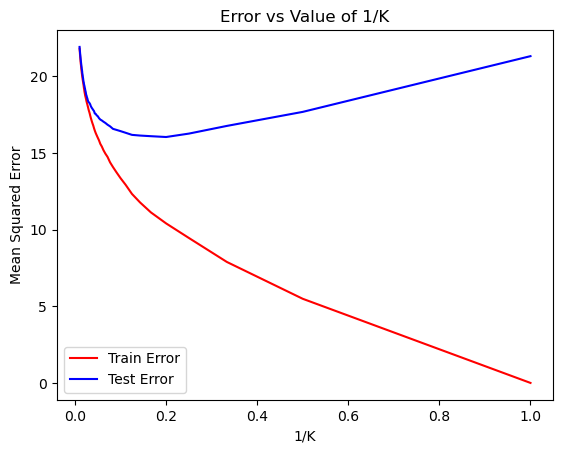

Best K: 5 with MSE: 16.034


In [22]:
# compute training error
trainErrorDict = KNNRegression(trainDataX, trainDataY, trainDataX, trainDataY)

# compute testing error
testErrorDict = KNNRegression(trainDataX, trainDataY, testDataX, testDataY)

# plot training and testing error vs 1/K
plotTrainTestError(trainErrorDict, testErrorDict, 'Train Error', 'Test Error')

# find value of K with minimum testing error
sortedTestErrorDict = sorted(testErrorDict.items(), key=operator.itemgetter(1))
bestK = int(round(1/sortedTestErrorDict[0][0]))
KNNMSE = sortedTestErrorDict[0][1]
print('Best K:', bestK, 'with MSE:', KNNMSE)  

# KNN Regression with normalization.

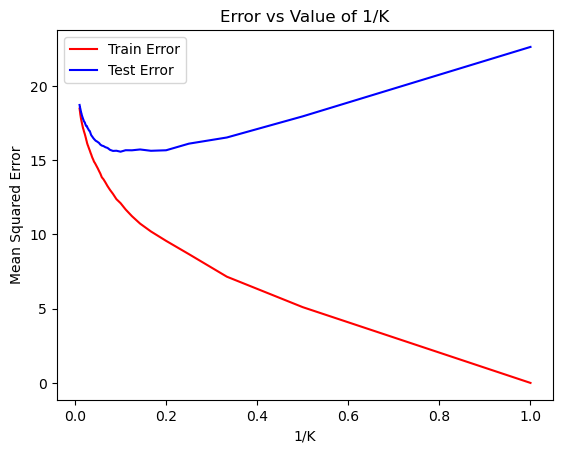

Best K: 10 with MSE: 15.566


In [23]:
# normalize data
normalizedTrainDataX, normalizedTestDataX = normalizeFeatureData(trainDataX, testDataX)

# compute training error
trainErrorDict = KNNRegression(normalizedTrainDataX, trainDataY, normalizedTrainDataX, trainDataY)

# compute testing error
testErrorDict = KNNRegression(normalizedTrainDataX, trainDataY, normalizedTestDataX, testDataY)

# plot training and testing error vs 1/K
plotTrainTestError(trainErrorDict, testErrorDict, 'Train Error', 'Test Error')

# find value of K with minimum testing error
sortedTestErrorDict = sorted(testErrorDict.items(), key=operator.itemgetter(1))
bestK = int(round(1/sortedTestErrorDict[0][0]))
normalizedKNNMSE = sortedTestErrorDict[0][1]
print('Best K:', bestK, 'with MSE:', normalizedKNNMSE)

# (j) Compare KNN with linear

In [24]:
tableData = []
row = []
row.append('Complete Regression Model')
row.append(model1TestMSE)
tableData.append(row)

row = []
row.append('Regression Model with Only Significant Features')
row.append(model2TestMSE)
tableData.append(row)

row = []
row.append('KNN Regression Without Normalization')
row.append(KNNMSE)
tableData.append(row)

row = []
row.append('KNN Regression With Normalization')
row.append(normalizedKNNMSE)
tableData.append(row)

tableHeaders = ['Model', 'Test Mean Squared Error']
printDatainTable(tableHeaders, tableData)

print("\n\nAnalysis: ")
print("KNN Regression employs a non-parametric methodology and makes no assumptions regarding the nature of the decision boundary. A parametric method called linear regression fits the data by presuming a specific shape for the decision boundary. The test error for both KNN Regression and Linear Regression on this dataset is essentially equal. The key distinction between the two methods is that KNN Regression cannot identify the key predictors. However, by retraining the linear regression model, we may eliminate irrelevant factors.")

+-------------------------------------------------+-------------------------+
|                      Model                      | Test Mean Squared Error |
+-------------------------------------------------+-------------------------+
|            Complete Regression Model            |          18.09          |
+-------------------------------------------------+-------------------------+
| Regression Model with Only Significant Features |         18.608          |
+-------------------------------------------------+-------------------------+
|      KNN Regression Without Normalization       |         16.034          |
+-------------------------------------------------+-------------------------+
|        KNN Regression With Normalization        |         15.566          |
+-------------------------------------------------+-------------------------+


Analysis: 
KNN Regression employs a non-parametric methodology and makes no assumptions regarding the nature of the decision boundary. A par

# 2. ISLR 2.4.1

## (a) The sample size n is extremely large, and the number of predictors p is small.

> ### Answer : Better - With the big sample size, a more flexible method will fit the data more closely and yield a better fit than an inflexible one.


## (b) The number of predictors p is extremely large, and the number of observations n is small.

> ### Answer: worse - A flexible approach would match the few observations too closely.


## (c) The relationship between the predictors and response is highly non-linear.

> ### Answer: better - a flexible model would achieve a better fit with more degrees of freedom.


## (d) The variance of the error terms, i.e. σ2 = Var(ϵ), is extremely high.

> ### Answer: Worse - flexible approaches increase variance and fit to the noise in the error terms.

# 3. ISLR 2.4.7

## (a) Compute the Euclidean distance between each observation and the test point, X1 = X2 = X3 = 0. 

> ### Answer: 
       Obs.   X1   X2   X3  Distance  Y
       ------------------------------------
       1      0    3    0   3        Red 
       2      2    0    0   2        Red
       3      0    1    3   3.16     Red
       4      0    1    2   2.24     Green
       5      -1   0    1   1.41     Green
       6      1    1    1   1.7      Red


## (b) What is our prediction with K = 1? Why?

> ### Answer: Green. Observation #5 is the closest neighbor for K = 1.


## (c) What is our prediction with K = 3? Why?

> ### Answer: Red. Observations #2, 5, 6 are the closest neighbors for K = 3. 2 is Red, 5 is Green, and 6 is Red.


## (d) If the Bayes decision boundary in this problem is highly nonlinear, then

> ### Answer: Small. A small K would be flexible for a non-linear decision boundary, whereas a large K would try to fit a more linear boundary because it takes more points into consideration.